# Домашнее задание
## Реализация алгоритма Deep Feature Interpolation

### План

1. Изучите алгоритм, описанный в [статье](https://arxiv.org/pdf/1611.05507.pdf).
2. Скачайте датасет (`faces.tar`) и разархивируйте его.
3. Реализуйте алгоритм **Deep Feature Interpolation**.
4. Продемонстрируйте результаты работы на произвольном изображении.

### Критерии оценки

* реализация базового алгоритма (с демонстрацией работы на каком-нибудь изображении из выборки): **50 баллов**
* визуализация интерполяции (варьировать степень модификации изменением $\alpha$): **30 баллов**
* применить алгоритм к какой-нибудь картике не из выборки (с применением детектора и вставкой обратно): **20 баллов**

### Подсказки

* для экономии памяти предлагается хранить в индексе не сами вектора, а их проекции на меньшее пространство (например, в качестве базиса использовать top-256 PCA, посчитанный на 5К-10К объектах выборки), а когда нужно посчитать вектор-смещение, просто пересчитывать необходимое количество
* поэкспериментируйте со взвешиванием основного лосса и полной вариации
* экспериментируйте на изображениях меньшего разрешения (например, 64х64)

In [1]:
from PIL import Image
import numpy as np
import os

import torch
import torch.nn as nn
import torchvision

import matplotlib.pyplot as plt
%matplotlib inline

IMAGE_SIZE = 128

In [2]:
DEVICE_ID = 3 
DEVICE = torch.device('cuda:%d' % DEVICE_ID) 
torch.cuda.set_device(DEVICE_ID)

### Загрузка данных

*Предоставляемый датасет был размечен классификатором, поэтому может содержать большое количество ошибок. Тем не менее, для выполнения данного задания это не так критично.*

In [3]:
def load_dataset(directory):
    header = []
    labels = []
    filepaths = []
    
    with open(os.path.join(directory, 'gt.csv')) as f:
        header = f.readline().strip().split()[1:]
        header = [h.lower() for h in header]
        for line in f:
            fields = line.strip().split()
            path = os.path.join(directory, fields[0])
            filepaths.append(path)
            labels.append(fields[1:])

    return (
        header,
        np.array(labels),
        np.array(filepaths)
    )

DATASET_DIRECTORY_PATH = './data/faces'  
header, labels, filepaths = load_dataset(DATASET_DIRECTORY_PATH)

print(f"{len(filepaths)} изображений в датасете")

202278 изображений в датасете


In [4]:
print("Содержимое датасета по категориям:")
for i in range(len(header)):
    print(header[i], ":")
    names, counts = np.unique(labels[:, i], return_counts=True)
    for j in range(len(names)):
        print(" * ", names[j], ":", counts[j])

Содержимое датасета по категориям:
race :
 *  asian : 16215
 *  caucasian : 186063
gender :
 *  female : 134736
 *  male : 67542
age :
 *  adult : 75318
 *  old : 62429
 *  senior : 43973
 *  young : 20558
facial_hair :
 *  beard : 6689
 *  mustache : 2541
 *  shaved : 193048


In [5]:
# функция для удобного взаимодействия с разметкой

def get_mask(**kwargs):
    mask = np.ones(len(filepaths), dtype=np.bool)
    for h in kwargs:
        if isinstance(kwargs[h], list):
            mask &= np.in1d(labels[:, header.index(h)], kwargs[h])
        else:
            mask &= labels[:, header.index(h)] == kwargs[h]
    return mask

def load_image(path, size=(IMAGE_SIZE, IMAGE_SIZE)):
    img = Image.open(path)
    img = img.convert("RGB")
    img = img.resize(size, Image.BICUBIC)
    return img

# примеры запросов
print("count(asian & female) =", get_mask(race='asian', gender='female').sum())
print("count(caucasian & male & shaved) =", get_mask(race='caucasian', gender='male', facial_hair='shaved').sum())

count(asian & female) = 11046
count(caucasian & male & shaved) = 53359


### Функция $\phi(x)$

Определим функцию отображения в признаковое пространство в виде `nn.Module`:


In [6]:
class Phi(nn.Module):
    def __init__(self, pretrained=True):
        super(Phi, self).__init__()

        model = torchvision.models.vgg19(pretrained=pretrained)
        layers = list(model.features)
        self.slice_0 = nn.Sequential(*layers[0:12])
        self.slice_1 = nn.Sequential(*layers[12:21])
        self.slice_2 = nn.Sequential(*layers[21:30])

        for param in self.parameters():
            param.requires_grad = False

    def forward(self, x):
        mean = x.new_tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = x.new_tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        x = (x - mean) / std
        
        xs = []

        x = self.slice_0(x)
        xs.append(x.view(x.shape[0], -1))
        
        x = self.slice_1(x)
        xs.append(x.view(x.shape[0], -1))
        
        x = self.slice_2(x)
        xs.append(x.view(x.shape[0], -1))
        
        return torch.cat(xs, dim=1)
    

to_tensor = torchvision.transforms.ToTensor()
to_image = torchvision.transforms.ToPILImage()

phi = Phi()

number of features per image:  425984


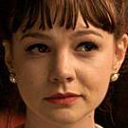

In [7]:
# пример использования

image = load_image(filepaths[0])
fx = phi(to_tensor(image).unsqueeze(0))[0]

print("number of features per image: ", fx.shape[0])
image

### Построение индекса базы

Извлеките признаки (функцией $\phi$) из изображений базы. По этим признакам вы будете искать похожие изображения, поэтому можно хранить их сжатое представление.

In [8]:
#import random
#my_randoms = random.sample(range(len(filepaths)), 5000)
#train_pca = filepaths[my_randoms]
#train_pca = [phi(to_tensor(load_image(tmp)).unsqueeze(0)) for tmp in train_pca]
#train_pca = np.vstack(train_pca)

In [9]:
#from sklearn.decomposition import PCA
#pca = PCA(n_components=256)
#pca.fit(train_pca)

In [10]:
import pickle
filename = 'pca_model.sav'
#pickle.dump(pca, open(filename, 'wb'))
pca = pickle.load(open(filename, 'rb'))

In [11]:
#from tqdm import tqdm_notebook as tqdm
#import torch.utils.data as dt

#train_list = dt.DataLoader(filepaths, shuffle=False, batch_size=1000)
#filepaths_pca = []

#for i in tqdm(train_list):
#    part = [to_tensor(load_image(tmp)).unsqueeze(0) for tmp in i]
#    part = torch.cat(part)
#    part = pca.transform(phi(part))
#    filepaths_pca.append(part)

In [12]:
#import pickle
 
#with open('filepaths_pca.pkl', 'wb') as f:
#    pickle.dump(filepaths_pca, f)

In [13]:
#pca_files = [j for i in filepaths_pca for j in i]

In [14]:
#import pickle
 
#with open('pca_files.pkl', 'wb') as f:
#    pickle.dump(pca_files, f)

In [15]:
import pickle
with open('pca_files.pkl', 'rb') as f:
    pca_files = pickle.load(f)

In [16]:
similarity_pca = [tmp.reshape(1,256) for tmp in pca_files]

### Функция подбора кандидатов

У нас есть база признаков, по которым мы можем искать изображения, похожие на запрос. Напишите функцию, которая для данного изображения `query` находит `n` наиболее похожих на него (по сжатому признаковому описанию) среди изображений, покрываемых бинарной маской `mask` (размер маски равен количеству изображений в базе). В качестве меры похожести можете использовать косинусную меру.

In [17]:
import heapq
def heapSearch( bigArray, k ):
    heap = []
    # Note: below is for illustration. It can be replaced by 
    # heapq.nlargest( bigArray, k )
    for item in bigArray:
        # If we have not yet found k items, or the current item is larger than
        # the smallest item on the heap,
        if len(heap) < k or item > heap[0]:
            # If the heap is full, remove the smallest element on the heap.
            if len(heap) == k: heapq.heappop( heap )
            # add the current element as the new smallest.
            heapq.heappush( heap, item )
    return heap

In [18]:
from itertools import compress
from sklearn.metrics.pairwise import cosine_similarity


def best_similar(pca_phi_target_image, mask, n=100):
    indexes = range(0,len(filepaths))
    index = list(compress(indexes, mask.tolist()))
    pca_mask = list(compress(similarity_pca, mask.tolist()))
    similar_images = [cosine_similarity(pca_phi_target_image, tmp) for tmp in pca_mask]
    top = heapSearch(similar_images,100)
    index = [index[tmp] for tmp in [similar_images.index(tmp) for tmp in top] ]

    return index

In [19]:
#TEST
target_image = load_image(filepaths[0])
target_image = to_tensor(target_image).unsqueeze(0)
phi_target_image = phi(target_image)
pca_phi_target_image = pca.transform(phi(target_image))
#best_similar(pca_phi_target_image, get_mask(race='caucasian', gender='male', facial_hair='shaved'))

### Вычисление центров кластеров

Используя функцию `best_similar` реализуйте функцию подсчёта центров кластеров в признаковом пространстве $\phi$ изображений, наиболее похожих на изображение-запрос. С использованием этой функции вы сможете для двух различных наборов атрибутов (например `caucasian & male` и `asian & male`) вычислить вектор-смещение, по которому мы будем "двигать" признаковое описание оптимизируемого изображения. 

*Заметьте, что если мы будем производить модификацию из `caucasian & male` в `asian & male`, то изображение, которое мы оптимизируем, должно принадлежать множеству `caucasian & male`, иначе результат может получиться так себе.*

In [20]:
def find_centr(pca_phi_target_image, mask, n=100):
    indexes = best_similar(pca_phi_target_image, mask, n)
    images = [phi(to_tensor(load_image(filepaths[tmp])).unsqueeze(0)) for tmp in indexes]
    return((sum(images)/n))

In [21]:
#TEST
#find_centr(pca_phi_target_image, get_mask(race='asian', gender='female'), n=100)

### Функция потерь

Реализуйте функцию потерь, которую мы будем минимизировать для выбранного изображения и вычисленного для него вектора смещения.

In [22]:
class TVLoss(nn.Module):
    def __init__(self, eps=1e-3, beta=2):
        super(TVLoss, self).__init__()
        self.eps = eps
        self.beta = beta

    def forward(self, image_tensor):
        x = image_tensor[:, :, :-1, :-1] - image_tensor[:, :, :-1, 1:]
        y = image_tensor[:, :, :-1, :-1] - image_tensor[:, :, 1:, :-1]

        tensor = torch.clamp(x * x + y * y, self.eps)
        return torch.norm(tensor, self.beta / 2.0) ** (self.beta / 2.0)

### Оптимизиация

Напишите код оптимизиации изображения с использованием какого-нибудь оптимизатора.

In [29]:
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook as tqdm

%matplotlib inline
%env CUDA_VISIBLE_DEVICES=3

import torch as th
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision as tv
import torchvision.transforms as ts

from PIL import Image
import numpy as np
import os

env: CUDA_VISIBLE_DEVICES=3


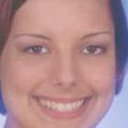

In [76]:
load_image('data/faces/images/' + os.listdir("data/faces/images")[16])

In [77]:
test_image = load_image('data/faces/images/' + os.listdir("data/faces/images")[16])

source_mask = get_mask(race="caucasian", age="adult", gender="female")
target_mask = get_mask(race="asian", age="old", gender="male")

pca_test = torch.tensor(pca.transform(phi(to_tensor(test_image).unsqueeze(0))))

source_phi = find_centr(pca_test, source_mask).to(DEVICE)
target_phi = find_centr(pca_test, target_mask).to(DEVICE)

W = target_phi - source_phi

In [78]:
MSE = nn.MSELoss().cuda()
TV = TVLoss().cuda()

In [125]:
def transpose(target_image, W, alpha=3,n_iter=30,lambd=0.001):

    
    target_image = target_image.to(DEVICE)
    W = W.to(DEVICE)
    phi.to(DEVICE)
    # инициализируем оптимизируемое изображение
    # из изображения контента, помечаем его как "оптимизируемое"
    image = target_image.clone().requires_grad_()


    optimizer = torch.optim.LBFGS([image])
    
    phi_shifted = phi(target_image) + alpha * W
  

    for i in tqdm(range(n_iter)):

        def closure():
            optimizer.zero_grad()
            loss = (0.5 * MSE(phi_shifted, phi(image)) 
                    + lambd * TV(image))
            loss.backward()
            return loss
    
        loss = optimizer.step(closure)
        # не забываем клипать изображение!
        image.data.clamp_(0, 1)
        
            
    phi.cpu()
    # "вырываем" тензор из графа
    return image.detach().cpu()

In [80]:
target_image = to_tensor(test_image).unsqueeze(0)

In [81]:
test = transpose(target_image,W)

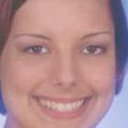

In [82]:
test_image

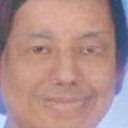

In [83]:
to_image(test.squeeze(0))

### Устранение артефактов (желательно)

В результате оптимизации на изображении могут появиться нежелательные артифакты в виде смещения цетовой палитры. Попробуйте побороть это вычитанием из результата разницы между исходным изображением и модифицированным изображением с параметром $\alpha=0$.

In [84]:
test = transpose(target_image,W,alpha=3)

In [85]:
artefacts = target_image - transpose(target_image,W,alpha=0)

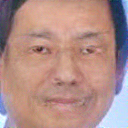

In [87]:
to_image((test + 1.5*artefacts).data.clamp_(0, 1).squeeze(0))

### Интерполяция в признаковом пространстве (бонус)

Постройте последовательность изображений с варьированием степени модификации.

In [91]:
images = []

for alpha in range(0,6):
    images.append(transpose(target_image,W,alpha=alpha))

In [95]:
images[0]

tensor([[[[0.4729, 0.4626, 0.4815,  ..., 0.4643, 0.4451, 0.4394],
          [0.4874, 0.4755, 0.4772,  ..., 0.4391, 0.4666, 0.4972],
          [0.5089, 0.4838, 0.4537,  ..., 0.4546, 0.4745, 0.5034],
          ...,
          [0.7761, 0.7873, 0.7607,  ..., 0.7028, 0.7006, 0.7124],
          [0.7465, 0.7705, 0.7622,  ..., 0.6960, 0.6752, 0.6932],
          [0.7263, 0.8010, 0.7891,  ..., 0.7140, 0.7012, 0.7083]],

         [[0.3705, 0.3549, 0.3508,  ..., 0.5769, 0.6043, 0.6359],
          [0.3821, 0.3602, 0.3360,  ..., 0.5587, 0.6057, 0.6304],
          [0.3684, 0.3457, 0.3151,  ..., 0.5499, 0.5859, 0.6174],
          ...,
          [0.7844, 0.8002, 0.7671,  ..., 0.7463, 0.7460, 0.7413],
          [0.7602, 0.7904, 0.7499,  ..., 0.7577, 0.7499, 0.7481],
          [0.7694, 0.8216, 0.7480,  ..., 0.7481, 0.7470, 0.7432]],

         [[0.3810, 0.3707, 0.3766,  ..., 0.7952, 0.8225, 0.8513],
          [0.3869, 0.3703, 0.3579,  ..., 0.7769, 0.8096, 0.8183],
          [0.3685, 0.3647, 0.3333,  ..., 0

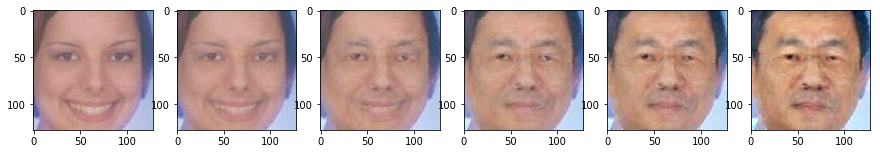

In [104]:
import numpy as np
import matplotlib.pyplot as plt


fig=plt.figure(figsize=(15, 5))
columns = 6
for i in range(1, columns +1):
    img = to_image(images[i-1].squeeze(0))
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

### Работа с изображениями не из базы (бонус)

Ниже приведена функция `get_face_bbox`, которая возращает координаты для кропа лица из изображения. Используйте её, чтобы вырезать изображение лица, произвести над ним какую-нибудь трансформацию (например, смена пола или расы), а затем вставить модифицированное изображение обратно.

In [141]:
import cv2


HAAR_CASCADE_FILEPATH = './data/haarcascade_frontalface_default.xml'
cascade = cv2.CascadeClassifier(HAAR_CASCADE_FILEPATH)
image = to_image(plt.imread("data/2.jpg"))

def get_face_bbox(image):
    faces = cascade.detectMultiScale(
        np.asarray(image),
        scaleFactor=1.3,
        minNeighbors=5,
        minSize=(50, 50),
        flags=cv2.CASCADE_SCALE_IMAGE)
    if len(faces) != 1:
        return None
    x, y, w, h = faces[0]
    return x, y, x + w, y + h

In [142]:
x0, y0, x1, y1 = get_face_bbox(image)
image = to_image(to_tensor(image)[:, y0:y1, x0:x1])
image = nn.functional.interpolate(to_tensor(image).unsqueeze(0), size=128).squeeze(0)
image = to_image(image)

In [143]:
test_image = image

In [151]:
source_mask = get_mask(race="caucasian", age="adult", gender="male")
target_mask = get_mask(race="asian", age="adult", gender="male")

pca_test = torch.tensor(pca.transform(phi(to_tensor(test_image).unsqueeze(0))))

source_phi = find_centr(pca_test, source_mask).to(DEVICE)
target_phi = find_centr(pca_test, target_mask).to(DEVICE)

W = target_phi - source_phi

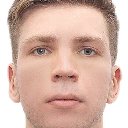

In [152]:
image

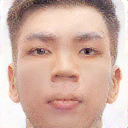

In [155]:
target_image = to_tensor(test_image).unsqueeze(0)
test = transpose(target_image,W)
to_image(test.data.clamp_(0, 1).squeeze(0))

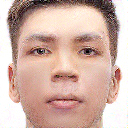

In [158]:
test = transpose(target_image,W,alpha=3)
artefacts = target_image - transpose(target_image,W,alpha=0)
to_image((test + 1.5*artefacts).data.clamp_(0, 1).squeeze(0))